# DLCV Assignment 1

**Due Date: 17/02/2023 11:59PM IST**

**Name:** 
Harsh Gupta

**Sr. No.:**
20961

In this assignment, we will cover the following topics:

1) Training a simple Linear Model 

2) Implementing Modules with Backprop functionality

3) Implementing Convolution Module on Numpy


It is crucial to get down to the nitty gritty of the code to implement all of these. No external packages (like caffe,pytorch etc), which directly give functions for these steps, are to be used. 

# Training a simple Linear Model

In this section, you will write the code to train a Linear Model. The goal is to classify an input $X_i$ of size $n$ into one of $m$ classes. For this, you need to consider the following:

1)  **Weight Matrix** $W_{n\times m}$: The Weights are multipled with the input $X_i$ (vector of size $n$), to find $m$ scores $S_m$ for the $m$ classes.

2)  **The Loss function**:   
  * The Cross Entropy Loss: By interpreting the scores as unnormalized log probabilities for each class, this loss tries to measure dissatisfaction with the scores in terms of the log probability of the right class:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where $f_{ y_i }$ is the $y_i$-th element of the output of $W^T  X_i$

3) **A Regularization term**: In addition to the loss, you need a Regularization term to lead to a more distributed (in case of $L_2$) or sparse (in case of $L_1$) learning of the weights. For example, with $L_2$ regularization, the loss has the following additional term:

$$
R(W) = \sum_k\sum_l W_{k,l}^2  
$$

Thus the total loss has the form:
$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

4) **An Optimization Procedure**: This refers to the process which tweaks the weight Matrix $W_{n\times m}$ to reduce the loss function $L$. In our case, this refers to Mini-batch Gradient Descent algorithm. We adjust the weights $W_{n\times m}$, based on the gradient of the loss $L$ w.r.t. $W_{n\times m}$. This leads to:
$$
W_{t+1} = W_{t} - \alpha \frac{\partial L}{\partial W},
$$
where $\alpha$ is the learning rate. Additionally, with "mini-batch" gradient descent, instead of finding loss over the whole dataset, we use a small sample $B$ of the training data to make each learning step. Hence,
$$
W_{t+1} = W_{t} - \alpha \frac{\partial \sum_{i \in B}{L_{x_i}}}{\partial W},
$$
where $|B|$ is the batch size.

**All downloaded Files Placed in "data/" folder** 

# Question 1

Train a **Single-Layer Classifier** for the MNIST dataset. 
* Use Softmax-Loss.
* Maintain a train-validation split of the original training set for finding the right value of $\lambda$ for the regularization, and to check for over-fitting.
* Finally, evaluate the classification performance on the test-set.


In [1]:
import numpy as np
import pandas as pd
import math
import struct
import pickle


import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split

############### Training Samples and Labels ###############


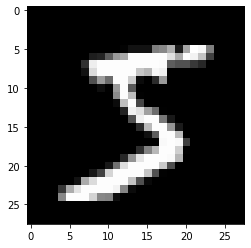

5
(60000, 28, 28)
(60000,)
############### Testing Samples and Labels ###############


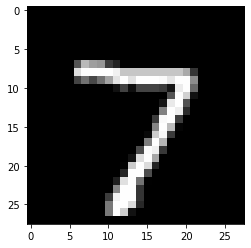

7
(10000, 28, 28)
(10000,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [2]:
## Load The Mnist data:
# Download data from http://yann.lecun.com/exdb/mnist/
# load the data.


####### train_images and labels #############
with open('data/train-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    train_imgs = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    train_imgs = train_imgs.reshape((size, nrows, ncols))
    
print("############### Training Samples and Labels ###############")
plt.imshow(train_imgs[0,:,:], cmap='gray')
plt.show()


with open('data/train-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    train_labels = train_labels.reshape((size,)) # (Optional)
print(train_labels[0])
print(train_imgs.shape)
print(train_labels.shape)


####### test_images and labels #############

with open('data/t10k-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    test_imgs = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_imgs = test_imgs.reshape((size, nrows, ncols))
    
print("############### Testing Samples and Labels ###############")
plt.imshow(test_imgs[0,:,:], cmap='gray')
plt.show()


with open('data/t10k-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    test_labels = test_labels.reshape((size,)) # (Optional)
print(test_labels[0])
print(test_imgs.shape)
print(test_labels.shape)


classes= set(test_labels)
print(classes)

    

# maintain a train-val split

# Now, write a generator that yields (random) mini-batches of the input data
###### mini batch generator    
def get_minibatch(training_x ,training_y ,batch_size=64):
    ## Read about Python generators if required.

    ## WRITE CODE HERE
    indices = np.arange(len(training_x))
    np.random.shuffle(indices)
    
    for i in range(0, len(training_x), batch_size):
        mini_x = training_x[indices[i:i+batch_size]]
        mini_y = training_y[indices[i:i+batch_size]]
        yield mini_x, mini_y    


In [3]:
######### train validation split ###########
def train_val_split(X,y,train_size=0.9):
    ids = X.shape[0]
    r=list(range(ids))
    np.random.shuffle(r)
    samples = int(ids*train_size)
    X_train, X_val, y_train, y_val = X[r[:samples]],X[r[samples:]],y[r[:samples]],y[r[samples:]]
#     print(X_train.shape, y_train.shape,X_train.shape, y_train.shape)
    return X_train, X_val, y_train, y_val


train_imgs, val_imgs ,train_labels, val_labels = train_val_split(train_imgs,train_labels)


In [4]:
# Define the class for a Single Layer Classifier
class Single_layer_classifier():
    
    def __init__(self, input_size, output_size):
        
        ## WRITE CODE HERE
        self.weights = np.random.normal(loc=0,scale=0.001 ,size= (input_size,output_size))
#         self.weights = np.random.rand(input_size,out///put_size)/math.sqrt(60000)
        self.bias = np.random.normal(loc=0,scale=0.001 ,size= (1,output_size))
        # Give the instance a weight matrix, initialized randomly
        # One possible strategy for a good initialization is Normal (0, σ) where σ = 1e-3.
        # Try experimenting with different values of σ.
        
    # Define the forward function
    def forward(self, input_x):
        # get the scores

        scores = np.matmul(self.weights.T,input_x)    #+ self.bias.T
        
        
        
        return scores
    
    # Similarly a backward function
    # we define 2 backward functions (as Loss = L_data + L_reg, grad(Loss) = grad(L1) + grad(L2))
    
    def backward_Ldata(self, grad_from_loss,x_i):
        
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the loss w.r.t. the corresponding element of W
        
        x_i = x_i.reshape(x_i.shape[0],1)
        grad_matrix =  np.matmul(x_i,grad_from_loss.T)
        return grad_matrix
        
    def backward_Lreg(self):
        
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the regularization-term
        # w.r.t. the corresponding element of W
        
        grad_matrix = 2*self.weights
        
        return grad_matrix
    
    def backward(self,eta,lmbda,grad_matrix):
        self.weights = self.weights - eta*(grad_matrix + lmbda*self.backward_Lreg())
        

In [5]:
# Implement the Softmax loss function
def loss_function(scores,input_y):
    
    eps = 0.001
    fyi = sum(np.exp(scores)) + eps
    return math.log(fyi) - scores[np.argmax(input_y)] 


def loss_backward(scores,input_y):
    fyi = np.exp(scores)/sum(np.exp(scores))
    fyi = fyi.reshape(10,1)                          
    grad_from_loss = np.subtract(fyi,input_y)
    return grad_from_loss
        

### Create utility functions for calculating training and validation accuracy

In [6]:
# WRITE CODE HERE
def getOneHotEncoding(y):
    one_hot = np.zeros(shape=(10,1))
    one_hot[y] = 1.0
    return one_hot

100%|███████████████████████████████████████████| 50/50 [01:00<00:00,  1.21s/it]

Min Loss is:  0.028900344534319587


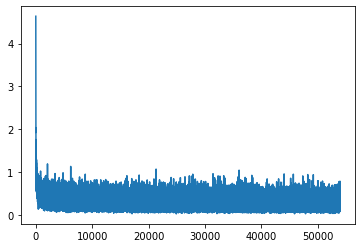

In [7]:
# Finally the trainer:
# Make an instance of Single_layer_classifier
input_size = 784
output_size= 10
batch_size=50
epochs =50
min_loss=100
model = Single_layer_classifier(input_size,output_size)

###  Train on the train-set obtained from train-validation split
batch_losses = []
for epoch in trange(epochs):
    
    ###  Use the mini-batch generator to get each mini-batch
    train_batches = get_minibatch(train_imgs,train_labels,batch_size)
    for iter_num,(input_x , input_y) in enumerate(train_batches):
        input_x = input_x
        input_x = input_x.reshape(input_x.shape[0],-1)
        ####### ----- batch ---- ######
        
        grads_emp = []
        loss = []
        ##### Forward Pass ##############
        for i in range(batch_size):
            scores = model.forward(input_x[i])
            loss.append(loss_function(scores,getOneHotEncoding(input_y[i])))
            grad_for_loss = loss_backward(scores,getOneHotEncoding(input_y[i]))
            grads_emp.append(model.backward_Ldata(grad_for_loss,input_x[i]))
            
        ##### Backward Pass ##############
        loss_p = sum(loss)/batch_size
        batch_losses.append(loss_p)
        min_loss = min(min_loss,loss_p)
        gd = np.array(sum(grads_emp))/batch_size
        model.backward(eta=0.000001,lmbda=0.02,grad_matrix = gd)
    
        ####### /----- batch ----/ ######
        
plt.plot(batch_losses)
print("Min Loss is: ",min_loss)  


In [8]:
from sklearn.metrics import classification_report, confusion_matrix

######### training Classification Report ########
print("\n\n######### training Classification Report ########\n\n")

y_pred =[]
for input_x in train_imgs:
    input_x = input_x.reshape(28*28,1)
    scores = model.forward(input_x)
    y_pred.append(np.argmax(scores))
print(classification_report(y_pred,train_labels))


######### Test Classification Report ########
print("\n\n######### Test Classification Report ########\n\n")
y_test_pred =[]
for input_x in test_imgs:
    input_x = input_x.reshape(28*28,1)
    scores = model.forward(input_x)
    y_test_pred.append(np.argmax(scores))

print(classification_report(y_test_pred,test_labels))
    





######### training Classification Report ########


              precision    recall  f1-score   support

           0       0.97      0.96      0.97      5372
           1       0.98      0.96      0.97      6169
           2       0.91      0.93      0.92      5250
           3       0.90      0.92      0.91      5329
           4       0.94      0.93      0.94      5257
           5       0.88      0.90      0.89      4845
           6       0.97      0.95      0.96      5443
           7       0.94      0.95      0.94      5589
           8       0.90      0.90      0.90      5259
           9       0.92      0.90      0.91      5487

    accuracy                           0.93     54000
   macro avg       0.93      0.93      0.93     54000
weighted avg       0.93      0.93      0.93     54000



######### Test Classification Report ########


              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1002
           1       0.98     

### Plot the training loss

Training_loss is as follows:


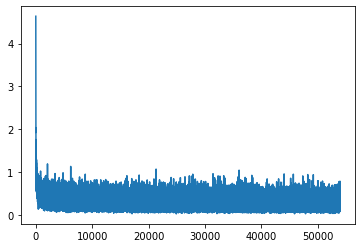

In [9]:
# WRITE CODE HERE
print("Training_loss is as follows:")
plt.plot(batch_losses)




### Find the accuracy on the validation set

In [10]:
# WRITE CODE HERE

######### Validation_set Classification Report ########
print("\n\n######### Validation_set Classification Report ########\n\n")

y_val_pred =[]
for input_x in val_imgs:
    input_x = input_x.reshape(28*28,1)
    scores = model.forward(input_x)
    y_val_pred.append(np.argmax(scores))

print(classification_report(y_val_pred,val_labels))



######### Validation_set Classification Report ########


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       579
           1       0.97      0.95      0.96       705
           2       0.90      0.94      0.92       592
           3       0.88      0.92      0.90       615
           4       0.94      0.93      0.94       614
           5       0.87      0.87      0.87       506
           6       0.96      0.93      0.95       599
           7       0.93      0.92      0.93       620
           8       0.86      0.85      0.86       596
           9       0.89      0.89      0.89       574

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


Batch size: 50, Learning rate: 0.0001, Lambda: 0, Val loss: 0.03675659159145756, Val accuracy: 0.8775


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


Batch size: 50, Learning rate: 0.0001, Lambda: 0.02, Val loss: 0.034822222940287875, Val accuracy: 0.871


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


Batch size: 50, Learning rate: 0.0001, Lambda: 0.002, Val loss: 0.03350544738944487, Val accuracy: 0.8851666666666667


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


Batch size: 50, Learning rate: 1e-05, Lambda: 0, Val loss: 0.0063046886814738376, Val accuracy: 0.9135


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]


Batch size: 50, Learning rate: 1e-05, Lambda: 0.02, Val loss: 0.006576454120073651, Val accuracy: 0.9033333333333333


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


Batch size: 50, Learning rate: 1e-05, Lambda: 0.002, Val loss: 0.006525222488747808, Val accuracy: 0.9073333333333333


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


Batch size: 50, Learning rate: 1e-06, Lambda: 0, Val loss: 0.0065593296901984965, Val accuracy: 0.9066666666666666


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


Batch size: 50, Learning rate: 1e-06, Lambda: 0.02, Val loss: 0.006666332451386384, Val accuracy: 0.9045


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


Batch size: 50, Learning rate: 1e-06, Lambda: 0.002, Val loss: 0.006634758803672476, Val accuracy: 0.9046666666666666


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


Batch size: 50, Learning rate: 1e-07, Lambda: 0, Val loss: 0.010421695927682901, Val accuracy: 0.8441666666666666


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


Batch size: 50, Learning rate: 1e-07, Lambda: 0.02, Val loss: 0.009975162564048862, Val accuracy: 0.8463333333333334


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]

Batch size: 50, Learning rate: 1e-07, Lambda: 0.002, Val loss: 0.010016247570203406, Val accuracy: 0.853


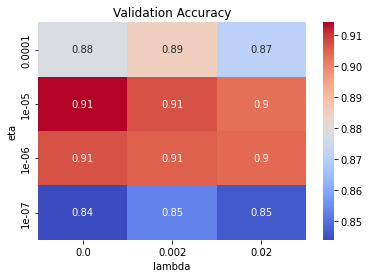

In [11]:
# The next step is to find the optimal value for lambda, number of epochs, learning rate and batch size. 
# CHOSE ANY TWO from the above mentioned to tune.
# Create plot and table to show the effect of the hparams.
etas=[0.0001,0.00001,0.000001, 0.0000001]
lambdas=[0, 0.02, 0.002 ]
def tune_hyperparameters(train_imgs, train_labels, val_imgs, val_labels, 
                         input_size, output_size, num_epochs=5, 
                         batch_sizes=[50], etas=etas, 
                         lambdas=lambdas):
    
    results = []
    
    for batch_size in batch_sizes:
        for eta in etas:
            for lmbda in lambdas:
                
                model = Single_layer_classifier(input_size, output_size)
                batch_losses = []
                
                for epoch in trange(num_epochs):

                    train_batches = get_minibatch(train_imgs, train_labels, batch_size)
                    for iter_num, (input_x, input_y) in enumerate(train_batches):
                        input_x = input_x
                        input_x = input_x.reshape(input_x.shape[0], -1)
                        grads_emp = []
                        loss = []

                        for i in range(batch_size):
                            scores = model.forward(input_x[i])
                            loss.append(loss_function(scores, getOneHotEncoding(input_y[i])))
                            grad_for_loss = loss_backward(scores, getOneHotEncoding(input_y[i]))
                            grads_emp.append(model.backward_Ldata(grad_for_loss, input_x[i]))

                        loss_p = sum(loss) / batch_size
                        batch_losses.append(loss_p)
                        gd = np.array(sum(grads_emp)) / batch_size
                        model.backward(eta=eta, lmbda=lmbda, grad_matrix=gd)

                    val_batches = get_minibatch(val_imgs, val_labels, batch_size)
                    val_acc = 0
                    val_loss = 0
                    for iter_num, (input_x, input_y) in enumerate(val_batches):
                        input_x = input_x
                        input_x = input_x.reshape(input_x.shape[0], -1)
                        grads_emp = []
                        loss = []
                        acc = 0

                        for i in range(batch_size):
                            scores = model.forward(input_x[i])
                            loss.append(loss_function(scores, getOneHotEncoding(input_y[i])))
#                             grad_for_loss = loss_backward(scores, getOneHotEncoding(input_y[i]))
#                             grads_emp.append(model.backward_Ldata(grad_for_loss, input_x[i]))
                            predicted_label = np.argmax(scores)
                            actual_label = input_y[i]
                            if predicted_label == actual_label:
                                acc += 1

                        loss_p = sum(loss) / batch_size
                        val_loss += loss_p
                        val_acc += acc

                    val_loss /= len(val_imgs)
                    val_acc /= len(val_imgs)

                    batch_losses.append(loss_p)

                results.append({
                    'batch_size': batch_size,
                    'learning_rate': eta,
                    'lambda': lmbda,
                    'val_loss': val_loss,
                    'val_accuracy': val_acc
                })

                print(f'Batch size: {batch_size}, Learning rate: {eta}, Lambda: {lmbda}, Val loss: {val_loss}, Val accuracy: {val_acc}')
                
    return results


def plot_tuning_results(results):
    # Create a table of the performance metrics
    df = pd.DataFrame(results, columns=['lambda', 'learning_rate', 'val_loss', 'val_accuracy'])
    df = df.pivot(index='learning_rate', columns='lambda', values='val_accuracy')
    df = df.round(3)

    # Create heatmap
    ax = sns.heatmap(df, annot=True, cmap='coolwarm')
    ax.invert_yaxis()
    ax.set_title('Validation Accuracy')
    ax.set_xlabel('lambda')
    ax.set_ylabel('eta')
    plt.show()
    
results = tune_hyperparameters(train_imgs, train_labels, val_imgs, val_labels, input_size=784, output_size=10)
plot_tuning_results(results)

### Find the best performing class and the worst performing class

In [12]:
print("The best performing class from the model trained above is : class 0 and class 1 with accuracy(97%)" )
print("The worst performing class from the model trained above is : class 8 with accuracy (88%)" )

The best performing class from the model trained above is : class 0 and class 1 with accuracy(97%)
The worst performing class from the model trained above is : class 8 with accuracy (88%)


# Training a Linear Classifier on MNIST from scikit-learn

In this section you have to train a linear classifier from the scikit-learn library and compare its results against your implementation.
(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [13]:
print("###### Sklearn RidgeClassifier Accuracy #########")
from sklearn.linear_model import RidgeClassifier
X=train_imgs.reshape(train_imgs.shape[0],-1)
y=train_labels
print()
rc = RidgeClassifier().fit(X, y)

####### Train Accuracy #######
print("############# Train Accuracy #################")

print(classification_report(rc.predict(X),train_labels))

####### Test Accuracy #######
print("############# Test Accuracy #################")
print(classification_report(rc.predict(test_imgs.reshape(test_imgs.shape[0],-1)),test_labels))






###### Sklearn RidgeClassifier Accuracy #########

############# Train Accuracy #################
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5692
           1       0.97      0.82      0.89      7174
           2       0.80      0.91      0.85      4720
           3       0.84      0.83      0.84      5523
           4       0.89      0.84      0.86      5565
           5       0.74      0.87      0.80      4163
           6       0.93      0.89      0.91      5526
           7       0.87      0.87      0.87      5621
           8       0.76      0.84      0.80      4712
           9       0.80      0.81      0.81      5304

    accuracy                           0.86     54000
   macro avg       0.86      0.86      0.86     54000
weighted avg       0.86      0.86      0.86     54000

############# Test Accuracy #################
              precision    recall  f1-score   support

           0       0.96      0.91      0.9

### Compare the training and test accuracies for the your implementation and linear classifier from scikit-learn

In [14]:
from sklearn.metrics import accuracy_score
############## Implemented Model Accuracy ##########
print("############## Implemented Model Accuracy ##########\n")

print("Test Accuracy:{} \t Train Accuracy: {}\n".format(accuracy_score(y_test_pred,test_labels)*100,accuracy_score(y_pred,train_labels)*100) )

print("############## Sklearn RidgeClassifier Accuracy ##########\n")
print("Test Accuracy:{} \t Train Accuracy: {}\n".format(accuracy_score(rc.predict(test_imgs.reshape(test_imgs.shape[0],-1)),test_labels)*100,accuracy_score(rc.predict(train_imgs.reshape(train_imgs.shape[0],-1)),train_labels)*100) )



############## Implemented Model Accuracy ##########

Test Accuracy:92.29 	 Train Accuracy: 93.04814814814814

############## Sklearn RidgeClassifier Accuracy ##########

Test Accuracy:85.95 	 Train Accuracy: 85.78333333333333



# Implementing Backpropagation

Now that you have had some experience with single layer networks, we can proceed to more complex architectures. But first we need to completely understand and implement backpropagation.

## Backpropagation:

Simply put, a way of computing gradients of expressions through repeated application of chain rule. If
$$
L = f (g (h (\textbf{x})))
$$
then, by the chain rule we have:
$$
\frac{\partial L}{\partial \textbf{x}} = \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial h} \cdot \frac{\partial h}{\partial \textbf{x}} 
$$

** Look into the class Lecture for more detail **



# Question 2 : Scalar Backpropagation

Evaluate the gradient of the following function w.r.t. the input:

$$ f(x,y,z) =  log(\sigma(\frac{cos(\pi \times x)+sin(\pi \times y/2)}{tanh(z^2)}))$$
where $\sigma$ is the sigmoid function. Find gradient for the following inputs:
  * $(x,y,z)$ =  (2,4,1)
  * $(x,y,z)$ =  (9,14,3)
  * $(x,y,z)$ =  (128,42,666)
  * $(x,y,z)$ =  (52,14,28)

      

In [15]:
# To solve this problem, construct the computational graph
# Write a class with forward and backward functions, for each node if you like
# For eg:
class tanh():
    def __init__(self):
        self.f = None
        
    def forward(self,x):
        self.f = np.tanh(x)
        return self.f
        # save values useful for backpropagation
    def backward(self):
        if self.f==None:
            print("Forward Propagation Not Done Yet.")
            return
        else:
            return (1-np.square(self.f))
class log():
    def __init__(self):
        self.f = None
        self.x=None
    def forward(self,x):
        self.f = np.log(x)
        self.x = x
        return self.f
        # save values useful for backpropagation
    def backward(self):
        if self.f==None or self.x==None:
            print("Forward Propagation Not Done Yet.")
            return
        else:
            return 1/(self.x)

class Sigmoid():
    def __init__(self):
        self.f = None
        
    def forward(self,x):
        self.f = 1/(1+np.exp(-x))
        # save values useful for backpropagation
    def backward(self):
        if self.f==None:
            print("Forward Propagation Not Done Yet.")
            return
        else:
            return self.f*(1-self.f)
# CAUTION: Carefully treat the input and output dimension variation. At worst, handle them with if statements.

In [16]:
# Now write the class func
# which constructs the graph (all operators), forward and backward functions.

class Func():
    def __init__(self):
        # construct the graph here
        # assign the instances of function modules to self.var
        self.x =None
        self.y =None
        self.z =None
        self.a = None
        self.b = None
        self.c = None
        self.d = None
        self.e = None
        self.f = None
        self.g = None
        self.h = None
        self.i = None
        self.j = None
        
        
        ###### x ######
        
        
        
    def forward(self,x,y,z):
        self.x ,self.y,self.z = x,y,z
        
        self.a = math.pi*self.x
        self.b = math.pi*self.y/2
        self.c = np.square(self.z)
        self.d = np.cos(self.a)
        self.e = np.sin(self.b)
        self.f = self.d + self.e
        self.g = np.tanh(self.c)
        self.h = np.divide(self.f,self.g)
        self.i = 1/(1+np.exp(-self.h))
        self.j = np.log(self.i)
        return self.j
        # Using the graph element's forward functions, get the output. 
        
    
    def backward(self):
        # Use the saved outputs of each module, and backward() function calls
        grad_x,grad_y,grad_z =1,1,1
        out = 1/self.i
        out *= self.i*(1-self.i)
        grad_xy  = out*1/self.g
        
        grad_x = (-1)*np.sin(self.a)*grad_xy
        grad_x = math.pi*(grad_x)
        
        grad_y = np.cos(self.b)*grad_xy
        grad_y = math.pi*grad_y/2
        
        
        grad_z = -out*self.f*(1/np.square(self.g))
        grad_z = grad_z*(1- np.square(self.g))
        grad_z = 2*self.z*grad_z
        return [grad_x,grad_y,grad_z]
    

#### Initialization #####
f= Func()

######### Forward and Backward Pass ############
x,y,z = 2.0,4.0,1.0
print("x:{}  y:{}  z:{}     forward:{}    backward:{}\n".format(x,y,z , f.forward(x,y,z),f.backward()))
x,y,z = 9.0,14.0,3.0
print("x:{}  y:{}  z:{}     forward:{}    backward:{}\n".format(x,y,z , f.forward(x,y,z),f.backward()))

x,y,z = 52.0,14.0,28.0
print("x:{}  y:{}  z:{}     forward:{}    backward:{}\n".format(x,y,z , f.forward(x,y,z),f.backward()))



x:2.0  y:4.0  z:1.0     forward:-0.23823101469115085    backward:[2.1417102890343507e-16, 0.43720979194276516, -0.3069722756588883]

x:9.0  y:14.0  z:3.0     forward:-1.3132617097862374    backward:[-2.5313688314302287e-15, -1.148344174369598, 2.672161875217988e-07]

x:52.0  y:14.0  z:28.0     forward:-0.31326168751822253    backward:[-6.626324387577344e-15, -0.42245219681098645, -0.0]



## Question 3 : Modular Vector Backpropagation

* Construct a Linear Layer module, implementing the forward and backward functions for arbitrary sizes.
* Construct a ReLU module, implementing the forward and backward functions for arbitrary sizes.
* Create a 2 layer MLP using the constructed modules.

* Modifying the functions built in Question 1 , train this two layer MLP for the same data set, MNIST, with the same train-val split.

In [17]:
# Class for Linear Layer (If you're stuck, you can refer to code of PyTorch/Tensorflow packages) 
class Linear_Layer:
    def __init__(self, input_size, output_size,batch_size,eta):
        self.input= None
        self.output= None
        self.eta = eta
        self.batch_size = batch_size
        self.weights = np.random.rand(input_size, output_size)*0.01/np.sqrt(input_size)
#         self.weights = np.random.normal(loc=0,scale=0.001 ,size= (input_size,output_size))

        self.gradient_matrix = np.zeros(shape=(input_size,output_size))
    
    def forward(self, input_data):
        self.input = input_data.reshape(input_data.shape[0],1)
        self.output = np.dot( self.weights.T, self.input)
        return self.output
    
    def backward_ldata(self,back_grad):
        for_grad = np.matmul( self.weights,back_grad)
        self.gradient_matrix = np.add(self.gradient_matrix,np.dot(self.input, back_grad.T))
        return for_grad    
        
        
    def backward(self):
        self.weights -= eta * self.gradient_matrix/self.batch_size
#         print(self.gradient_matrix)
        self.gradient_matrix = np.zeros(shape=self.weights.shape)
    
        
        

In [18]:
# Class for ReLU
class ReLU():
    def __init__(self):
        self.f = None
        self.x = None
    def forward(self,x):
        self.f = x*(x>0)
        self.x = x
        return self.f
    
    def backward_ldata(self,back_grad):
        return (self.x>0)*back_grad
    
    def backward(self):
        return 
    


In [19]:
# Your 2 layer MLP 
class MLP():
    def __init__(self):
        self.layers = []
        self.loss = []
    
    def add_layer(self,layer):
        self.layers.append(layer)
            
    def predict(self, input_data):
        samples = input_data.shape[0]
        result = []

        # run network over all samples
        
        for sample in input_data:
            # forward propagation
            
            scores = sample
            for layer in self.layers:
                scores = layer.forward(scores)
#                 print(output,end=' ')
                
            result.append(np.argmax(scores))
        return result

    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        fig = plt.figure(figsize=(10,10))
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()  
    
    
    def train(self,X,y,epochs=3,batch_size=50,eta=0.001):
        batch_losses = []
        min_loss =10000 
        print("#### training Started ####")
        for epoch in trange(epochs):
            print("epoch:{}   Total batches: {} ".format(epoch+1,X.shape[0]/batch_size))
            minibatch = get_minibatch(X,y,batch_size)
            loss =0
            for input_x , input_y in minibatch:
                for i in range(batch_size):
                    input_x = input_x.reshape(input_x.shape[0],-1)
                    scores = input_x[i]
                    ####### forward ##########
                    for layer in self.layers:
                        scores = layer.forward(scores)
#                         print("\n\n\n\n\n\n",scores)
                        
                        
                    ####### log(softmax calculation)
#                     print(scores)
                    loss += loss_function(scores,getOneHotEncoding(input_y[i]))
                    grad_for_loss = loss_backward(scores,getOneHotEncoding(input_y[i]))
                    
                    ####### backward sample wise to calculate gradient_matrix #######
                    for layer in reversed(self.layers):
                        grad_for_loss = layer.backward_ldata(grad_for_loss)


            
                self.loss.append(loss[0]/batch_size)
#                 print("loss: ", self.loss[-1])
                min_loss = min(min_loss,self.loss[-1])
                
                ##### weights update for each layer using backward
                for layer in self.layers:
                    layer.backward()
                loss=0
            print("Minimum Loss after epoch {} is  {}".format(epoch+1,min_loss))
#         self.plot_loss()
        print("Minimum Loss: ",min_loss)
    
        print("#### training Done ####")
        
    def valid(self,X,y,epochs=3,batch_size=50,eta=0.001):
        print("\n#########validation Started###########\n")
        correct =0
        total = X.shape[0]
        loss =0
        
        
        minibatch = get_minibatch(X,y,batch_size)
        for input_x , input_y in minibatch:
            for i in range(batch_size):
                input_x = input_x.reshape(input_x.shape[0],-1)
                scores = input_x[i]
                ####### forward ##########
                for layer in self.layers:
                    scores = layer.forward(scores)

                loss += loss_function(scores,getOneHotEncoding(input_y[i]))/total
                correct += (np.argmax(scores)==input_y[i])
            
        val_acc = correct/total
        val_loss = loss
        print(f'Batch size: {batch_size}, Learning rate: {eta}, Val loss: {val_loss[0]}, Val accuracy: {val_acc}')
        print("\n#########validation Done###########\n\n\n\n")
        
        return {
                    'batch_size': batch_size,
                    'learning_rate': eta,
                    'val_loss': val_loss[0],
                    'val_accuracy': val_acc,
                    'epochs': epochs
                }

        



In [20]:
####### hyperparameters ########
epochs = 2
batch_size =20
output_size = 10
input_size = 784
eta = 0.01

# Train the MLP
mlp = MLP()

##### add layer #####
mlp.add_layer(Linear_Layer(input_size,512,batch_size,eta))
mlp.add_layer(ReLU())

mlp.add_layer(Linear_Layer(512,256,batch_size,eta))
mlp.add_layer(ReLU())
mlp.add_layer(Linear_Layer(256,10,batch_size,eta))


mlp.train(train_imgs,train_labels,epochs,batch_size,eta)

#### training Started ####


  0%|                                                     | 0/2 [00:00<?, ?it/s]

epoch:1   Total batches: 2700.0 


 50%|██████████████████████▌                      | 1/2 [01:36<01:36, 96.33s/it]

Minimum Loss after epoch 1 is  0.0021847508237053948
epoch:2   Total batches: 2700.0 


100%|████████████████████████████████████████████| 2/2 [04:05<00:00, 122.67s/it]

Minimum Loss after epoch 2 is  0.00020572209897515848
Minimum Loss:  0.00020572209897515848
#### training Done ####


### Plot the training loss and training accuracy plot

Plot of training Loss is as follows: 


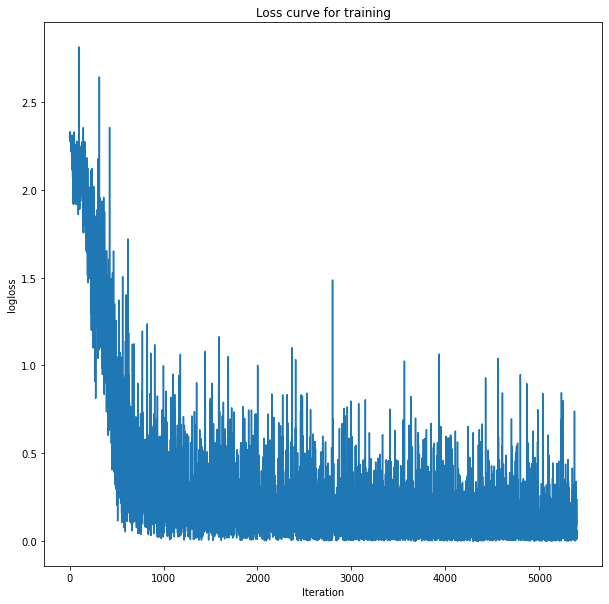

############ Training Accuracy Using MLP #################
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5474
           1       0.99      0.98      0.98      6101
           2       0.99      0.93      0.96      5661
           3       0.94      0.99      0.96      5180
           4       0.98      0.96      0.97      5335
           5       0.98      0.97      0.97      4926
           6       0.98      0.98      0.98      5326
           7       0.97      0.96      0.97      5673
           8       0.97      0.97      0.97      5272
           9       0.92      0.98      0.95      5052

    accuracy                           0.97     54000
   macro avg       0.97      0.97      0.97     54000
weighted avg       0.97      0.97      0.97     54000



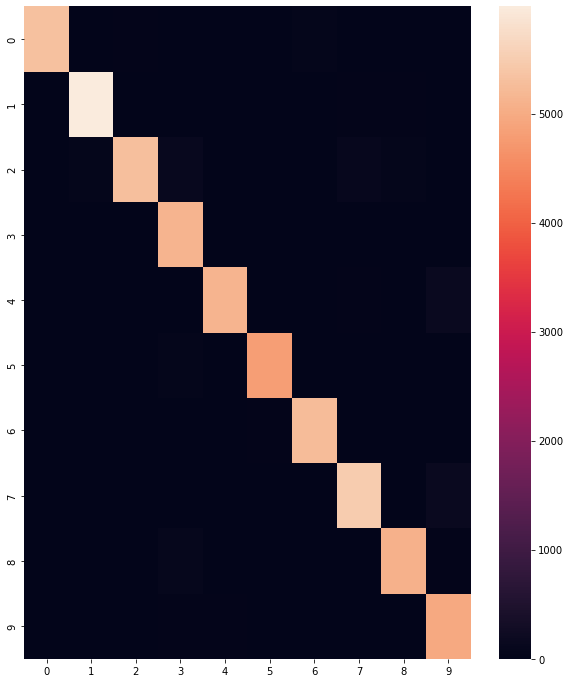

In [21]:
# Use the same utility functions defined in the previous question
# WRITE CODE HERE

from sklearn.metrics import classification_report, confusion_matrix
print("Plot of training Loss is as follows: ")
mlp.plot_loss()


print("############ Training Accuracy Using MLP #################")
y_train_pred =mlp.predict(train_imgs.reshape(train_imgs.shape[0],-1))
print(classification_report(y_train_pred,train_labels))
plt.figure(figsize=(10,12))
sns.heatmap(confusion_matrix(y_train_pred,train_labels))
plt.show()






### Find the accuracy on the validation set

In [22]:
# WRITE CODE HERE
print("############ Validation Accuracy Using MLP #################")
y_val_pred = mlp.predict(val_imgs.reshape(val_imgs.shape[0],-1))
plt.figure(figsize=(10,12))
print(classification_report(y_val_pred,val_labels))
# sns.heatmap(confusion_matrix(y_val_pred,val_labels))

############ Validation Accuracy Using MLP #################
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       588
           1       0.98      0.97      0.98       698
           2       0.98      0.93      0.96       657
           3       0.92      0.99      0.95       604
           4       0.97      0.94      0.96       623
           5       0.95      0.95      0.95       506
           6       0.98      0.97      0.98       590
           7       0.96      0.96      0.96       613
           8       0.96      0.94      0.95       601
           9       0.88      0.97      0.92       520

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000



<Figure size 720x864 with 0 Axes>

In [23]:
# Find the optimal value of learning rate and batch size. 
# Use the same tuning strategy as the previous question
# Create plot and table to show the effect of the hparams.
####### hyperparameters ########
# epochs_s = [2,5]
epochs = 20
etas = [0.01,0.001,0.0001]     # ,0.0001,0.00001
batch_size =50
batch_sizes = [20,50]
output_size = 10
input_size = 784

val_results =[]
for eta in etas:
    for batch_size in batch_sizes:
        
        mlp1 = MLP()
        ##### add layer #####
        mlp1.add_layer(Linear_Layer(input_size,512,batch_size,eta))
        mlp1.add_layer(ReLU())

        mlp1.add_layer(Linear_Layer(512,256,batch_size,eta))
        mlp1.add_layer(ReLU())
        mlp1.add_layer(Linear_Layer(256,10,batch_size,eta))
        mlp1.train(train_imgs,train_labels,epochs,batch_size,eta)
        val_results.append(mlp1.valid(val_imgs,val_labels,epochs,batch_size,eta))
        
        


#### training Started ####


  0%|                                                     | 0/2 [00:00<?, ?it/s]

epoch:1   Total batches: 2700.0 


 50%|██████████████████████                      | 1/2 [01:50<01:50, 110.48s/it]

Minimum Loss after epoch 1 is  0.002511138870020835
epoch:2   Total batches: 2700.0 


100%|████████████████████████████████████████████| 2/2 [03:31<00:00, 105.80s/it]

Minimum Loss after epoch 2 is  6.997773365160497e-05
Minimum Loss:  6.997773365160497e-05
#### training Done ####

#########validation Started###########



Batch size: 20, Learning rate: 0.01, Val loss: 0.17999404188314486, Val accuracy: 0.95

#########validation Done###########




#### training Started ####


  0%|                                                     | 0/2 [00:00<?, ?it/s]

epoch:1   Total batches: 1080.0 


 50%|██████████████████████▌                      | 1/2 [01:29<01:29, 89.28s/it]

Minimum Loss after epoch 1 is  0.033665639573130166
epoch:2   Total batches: 1080.0 


100%|█████████████████████████████████████████████| 2/2 [02:59<00:00, 89.76s/it]

Minimum Loss after epoch 2 is  0.010471405783255925
Minimum Loss:  0.010471405783255925
#### training Done ####

#########validation Started###########



Batch size: 50, Learning rate: 0.01, Val loss: 0.13537256842047157, Val accuracy: 0.9571666666666667

#########validation Done###########




#### training Started ####


  0%|                                                     | 0/2 [00:00<?, ?it/s]

epoch:1   Total batches: 2700.0 


 50%|██████████████████████                      | 1/2 [01:53<01:53, 113.87s/it]

Minimum Loss after epoch 1 is  0.9418511505099947
epoch:2   Total batches: 2700.0 


100%|████████████████████████████████████████████| 2/2 [03:58<00:00, 119.20s/it]

Minimum Loss after epoch 2 is  0.055882537539081234
Minimum Loss:  0.055882537539081234
#### training Done ####

#########validation Started###########



Batch size: 20, Learning rate: 0.001, Val loss: 0.32266504632074133, Val accuracy: 0.9056666666666666

#########validation Done###########




#### training Started ####


  0%|                                                     | 0/2 [00:00<?, ?it/s]

epoch:1   Total batches: 1080.0 


 50%|██████████████████████                      | 1/2 [01:51<01:51, 111.13s/it]

Minimum Loss after epoch 1 is  1.7995894309185476
epoch:2   Total batches: 1080.0 


100%|████████████████████████████████████████████| 2/2 [03:54<00:00, 117.03s/it]

Minimum Loss after epoch 2 is  1.469722521800201
Minimum Loss:  1.469722521800201
#### training Done ####

#########validation Started###########



Batch size: 50, Learning rate: 0.001, Val loss: 1.7608914386301329, Val accuracy: 0.25633333333333336

#########validation Done###########




#### training Started ####


  0%|                                                     | 0/2 [00:00<?, ?it/s]

epoch:1   Total batches: 2700.0 


 50%|██████████████████████                      | 1/2 [01:48<01:48, 108.23s/it]

Minimum Loss after epoch 1 is  1.8430327854342903
epoch:2   Total batches: 2700.0 


100%|████████████████████████████████████████████| 2/2 [03:54<00:00, 117.01s/it]

Minimum Loss after epoch 2 is  1.6243835581254236
Minimum Loss:  1.6243835581254236
#### training Done ####

#########validation Started###########



Batch size: 20, Learning rate: 0.0001, Val loss: 2.0524468286105684, Val accuracy: 0.09583333333333334

#########validation Done###########




#### training Started ####


  0%|                                                     | 0/2 [00:00<?, ?it/s]

epoch:1   Total batches: 1080.0 


 50%|██████████████████████                      | 1/2 [01:43<01:43, 103.92s/it]

Minimum Loss after epoch 1 is  2.231669821896662
epoch:2   Total batches: 1080.0 


100%|████████████████████████████████████████████| 2/2 [03:26<00:00, 103.02s/it]

Minimum Loss after epoch 2 is  2.0971492349713414
Minimum Loss:  2.0971492349713414
#### training Done ####

#########validation Started###########



Batch size: 50, Learning rate: 0.0001, Val loss: 2.2055055095717506, Val accuracy: 0.09583333333333334

#########validation Done###########






   batch_size  learning_rate  val_loss  val_accuracy  epochs
0          20         0.0100  0.179994      0.950000       2
1          50         0.0100  0.135373      0.957167       2
2          20         0.0010  0.322665      0.905667       2
3          50         0.0010  1.760891      0.256333       2
4          20         0.0001  2.052447      0.095833       2
5          50         0.0001  2.205506      0.095833       2


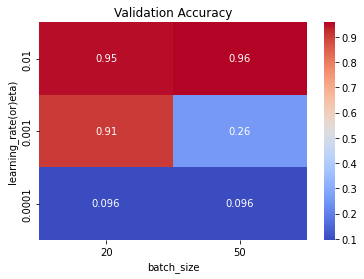

In [24]:
def plot_hyperparam_results(results):
    # Create a table of the performance metrics
    df = pd.DataFrame(results, columns=['batch_size', 'learning_rate', 'val_loss', 'val_accuracy','epochs'])
    
    print(df)
    df = df.pivot(index='learning_rate', columns='batch_size', values='val_accuracy')
    df = df.round(3)

    # Create heatmap
    ax = sns.heatmap(df, annot=True, cmap='coolwarm')
    ax.invert_yaxis()
    ax.set_title('Validation Accuracy')
    ax.set_xlabel('batch_size')
    ax.set_ylabel('learning_rate(or)eta)')
    plt.show()
print("\n######## Data Generated for 20 epochs ##########\n")
plot_hyperparam_results(val_results)

### Report final performance on MNIST test set

In [25]:
# WRITE CODE HERE
print("############ Test Accuracy Using MLP #################")
y_test_pred = mlp.predict(test_imgs.reshape(test_imgs.shape[0],-1))
plt.figure(figsize=(10,12))
print(classification_report(y_test_pred,test_labels))
# sns.heatmap(confusion_matrix(y_test_pred,test_labels))
print("The best and worst performing class is mentioned in given classification report of model trained above ......" )


############ Test Accuracy Using MLP #################
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1015
           1       0.99      0.98      0.98      1147
           2       0.98      0.92      0.95      1102
           3       0.94      0.99      0.96       957
           4       0.97      0.95      0.96      1002
           5       0.96      0.97      0.96       890
           6       0.97      0.98      0.97       947
           7       0.95      0.96      0.95      1018
           8       0.96      0.95      0.96       991
           9       0.91      0.98      0.94       931

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

The best and worst performing class is mentioned in given classification report of model trained above ......


<Figure size 720x864 with 0 Axes>


# Implementing a Convolution Module with Numpy

* This topic will require you to implement the Convolution operation using Numpy.
* We will use the Module for tasks like Blurring.
* Finally, we implement Backpropagation for the convolution module.


# Question 4

* Implement a naive Convolution module, with basic functionalities: kernel_size, padding, stride and dilation
  
* Test out the convolution layer by using it to do gaussian blurring on 10 random images of CIFAR-10 dataset


In [26]:
## Define a class Convolution Layer, which is initialized with the various required params:
class Convolution_Layer():
    
    def __init__(self,in_channels,out_channels,filter_size, bias=True, stride=1, padding=0, dilation=1,eta=0.00001):
        self.weights = np.random.normal(loc=0,scale=0.001 ,size= (out_channels,filter_size[0],filter_size[1],in_channels))//np.sqrt(np.product(filter_size)*in_channels*out_channels)
        self.filter_size = filter_size
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.stride = stride
        self.padding = 0 and padding
        self.dilation = dilation
        self.output= None
        self.eta = eta
        self.gradient_matrix = np.zeros(shape= (filter_size[0],filter_size[1],in_channels))
        
        print("Filter Weights Shape: ",self.weights.shape)
         
        # For an untrained layer, set random initial filter weights
    def convolve2D(self,Input,filter_w,mode="default"):
#         print("Convolve2D:\n") 
#         print(Input.shape)
        input_shape = Input.shape
        filter_shape = filter_w.shape
        df = len(filter_shape)
        di = len(input_shape)
        if di!=df: print("Dimension are different ie.e x shape {}!= f_shape{}".format(di,df))
        pdd= [(filter_shape[0]-1,filter_shape[0]-1),(filter_shape[1]-1,filter_shape[1]-1)]
        
        output = np.zeros(shape=(self.weights.shape[1],self.weights.shape[2]))
        
        if(mode=="full"):
            Input = np.pad(Input,pdd)
            output =np.zeros(shape=(self.input_v.shape[0],self.input_v.shape[1]))
            
        for i in range(0,output.shape[0],self.stride):
            for j in range(0,output.shape[1],self.stride):
                output[i,j] = np.sum(np.multiply(filter_w,Input[i:i+filter_shape[0],j:j+filter_shape[1]]))
        
        return output
            
    def forward(self,input_v,mode=""):
        h,w,d = input_v.shape
#         
        
        input_v = np.pad(input_v,[(self.padding, self.padding), (self.padding, self.padding),(0,0)],mode='constant')
        self.input_v = input_v
        hd,wd,dd = (h-self.filter_size[0]+2*self.padding)//self.stride + 1,(w-self.filter_size[1]+2*self.padding)//self.stride + 1, self.out_channels
        output = np.zeros(shape=(hd,wd,dd))


        for k in range(0,self.out_channels):
            for i in range(0,output.shape[0],self.stride):
                for j in range(0,output.shape[1],self.stride):
                    output[i,j,k] = np.sum(np.multiply(self.weights[k,:,:,:],input_v[i:i+self.filter_size[0],j:j+self.filter_size[1],:self.in_channels]))
        self.output = output

        return output



    def backward(self, output_gradient):
        input_gradient = np.zeros(shape=self.input_v.shape)
        
        weight_gradient = np.zeros(shape=self.weights.shape)
        
        for i in range(0,self.out_channels):
            for j in range(0,self.in_channels):
                weight_gradient[i,:,:,j] = self.convolve2D(self.input_v[:,:,j],output_gradient[:,:,i])
                input_gradient[:,:,j] += self.convolve2D(output_gradient[:,:,i],self.weights[i,:,:,j],mode="full")
        self.weights -= self.eta*weight_gradient
        return input_gradient
        
    
    def set_weights(self, new_weights):
            
        self.weights = new_weights
        
    

In [27]:


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

    

def gaussian_filter(image, kernel_size, sigma,cl):
    
    ########## kernel Implementation ##############
    kernel = np.zeros((kernel_size, kernel_size))
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i,j] = np.exp(-((i-kernel_size//2)**2 + (j-kernel_size//2)**2) / (2*sigma**2))
    
    kernel = kernel / np.sum(kernel)
    kernel = kernel.reshape(1,kernel_size,kernel_size,1)
    
    
    cl.set_weights(kernel)
    filtered_image = np.zeros(shape=(image.shape[0]-kernel_size+1,image.shape[1]-kernel_size+1,3))
    
    for i in range(image.shape[2]):
        filtered_image[:,:,i] = cl.forward(image[:,:,i:i+1])[:,:,0]
    return filtered_image

    
  



### Download CIFAR-10 images and load it in a numpy array (https://www.cs.toronto.edu/~kriz/cifar.html)



In [28]:
s=unpickle("data/cifar-10-batches-py/data_batch_1")    


### Initialize a conv layer. Set weights for gaussian blurring (do not train the filter for this part). Visualise the filters using matplotlib


In [29]:
b_imgs=[]
for i in range(5):
    img = s[b'data'][i].reshape(3,32,32).transpose(1,2,0)
    b_imgs.append(img)
    
       
cl = Convolution_Layer(1,1,(3,3))


Filter Weights Shape:  (1, 3, 3, 1)


### Generate output for the first 5 images of the training set

In [30]:
# WRITE CODE HERE
## gaussian blurring here ######

filtered_images = [[],[],[]]
for image in b_imgs[:5]:
    f_img = gaussian_filter(image,3,3,cl)
    f_img = f_img.astype(np.uint8)
    
    filtered_images[0].append(f_img[:,:,0])   # for Ist channel
    filtered_images[1].append(f_img[:,:,1])   # for IInd channel
    filtered_images[2].append(f_img[:,:,2])   # for IIIrd channel


### Use matplotlib to show the input and corresponding blurred output

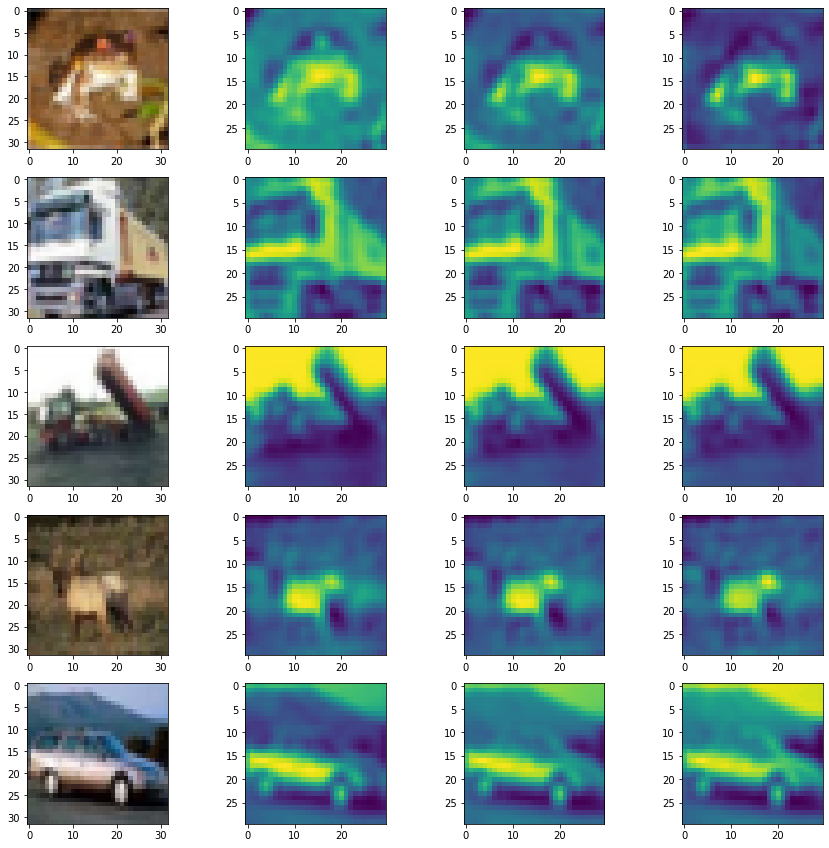

In [31]:

rows=5
cols = 4
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i in range(5):
    axes[i, 0].imshow(b_imgs[i])
    axes[i, 1].imshow(filtered_images[0][i])    
    axes[i, 2].imshow(filtered_images[1][i])    
    axes[i, 3].imshow(filtered_images[2][i])  

## Question 5
<br>
Now we will use this module for training a simple Convolution Layer using CIFAR-10 images. 

* The goal is to learn a set of weights, by using the backpropagation function created. To test the backpropagation, instead of training a whole network, we will train only a single layer.
  * Instantiate a Convolution  layer $C_0$ with 20 filters, each with size 5$\times$5 (RGB image, so 3 input channels). Load the given numpy array of size (20,3,5,5), which represents the weights of a convolution layer. Set the given values as the filter weights for $C_0$. Take 100 CIFAR-10 images. Save the output of these 100 images generated from this Convolution layer $C_0$. 
  
  * Now, initialize a new convolution layer $C$ with weight values sampled from uniform distribution [-1,1]. Use the $L_2$ loss between the output of this layer $C$ and the output generated in the previous step to learn the filter weights of $C_0$.


b'wherry_s_000037.png'
(100, 32, 32, 3) (100,)


8

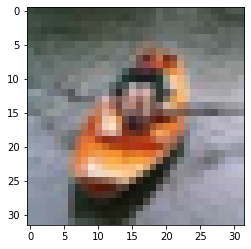

In [32]:
b_imgs = []
b_labels  = np.array(s[b'labels'])
###### choose the 100 shuffled images at random from 1st batch #######
for j in range(10000):
    img = s[b'data'][j].reshape(3,32,32).transpose(1,2,0)
    b_imgs.append(img)
b_imgs = np.array(b_imgs)    
ind = list(range(10000))
np.random.shuffle(ind)



train_imgs =b_imgs[ind[:100],:]
train_labels = b_labels[ind[:100]]
    
    
######## 15th example chosen from Dataset #####
print(s[b'filenames'][ind[15]])
print(train_imgs.shape,train_labels.shape)
plt.imshow(train_imgs[15])
train_labels[15]

In [33]:
## Load filter weights from given numpy array "C0_weights.npy".
## Init a conv layer C_0 with these given weights
x= train_imgs
train_imgs = (x - x.mean(axis=(0,1,2), keepdims=True)) / x.std(axis=(0,1,2), keepdims=True)

C0_weights = np.load("data/C0_weights.npy")
print(C0_weights.shape)
C0_weights = C0_weights.transpose(0,2,3,1)
print(C0_weights.shape)

## For all images get output. Store in numpy array.
C0_layer = Convolution_Layer(3,20,(5,5))
C0_layer.set_weights(C0_weights)
C0_output_imgs = []
for i in range(100):
    C0_output = C0_layer.forward(train_imgs[i])
    C0_output_imgs.append(C0_output)
C0_output_imgs = np.array(C0_output_imgs)

(20, 3, 5, 5)
(20, 5, 5, 3)
Filter Weights Shape:  (20, 5, 5, 3)


In [34]:
C0_output_imgs.shape

(100, 28, 28, 20)

In [35]:
# for part 2 we need to write a class for the  L2 loss
class L2_loss():
    def ___init__(self):
        self.f =None
    
    def forward(self, C0_output,C_output):
        # Conv. output is of dimension (batchsize,channels,height,width)
        # calculate the L2 norm of (C0_output - C_output)
        self.f = C0_output-C_output
        loss = np.linalg.norm(self.f)
        
        return loss
    def backward(self,output_grad):
        
        # from the loss, and the conv. output, get the grad at each location
        grad = -2*self.f
        # The grad is of the shape (batchsize,channels,height,width)
        return grad

# Now Init a new conv layer C and a L2 loss layer
C_weights = np.random.uniform(-1,1,size=C0_weights.shape)/np.sqrt(np.product(C0_weights.shape))

C_layer = Convolution_Layer(3,20,(5,5))
C_layer.set_weights(C_weights)

# Train the new conv-layer C using the L2 loss to learn C_0, i.e., the set of given weights.
epochs=100
l2_loss = L2_loss()
for epoch in range(epochs):
    loss= 0
    
    for i in trange(train_imgs.shape[0]):

        ## forward ###
        C_output = C_layer.forward(train_imgs[i])
        loss += l2_loss.forward(C0_output_imgs[i],C_output)/train_imgs.shape[0]

        ### backward ####
        loss_backward = l2_loss.backward(loss)
        C_layer.backward(loss_backward)
    
    
    print("epochs {}/{} and avg_loss: {}".format(epoch+1,epochs,loss))




Filter Weights Shape:  (20, 5, 5, 3)


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.30it/s]


epochs 1/300 and avg_loss: 152.1917417510378


100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.20it/s]


epochs 2/300 and avg_loss: 88.19339577773532


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


epochs 3/300 and avg_loss: 70.26217059591865


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


epochs 4/300 and avg_loss: 60.15395241828426


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]


epochs 5/300 and avg_loss: 53.415840991101405


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


epochs 6/300 and avg_loss: 48.46460017279395


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


epochs 7/300 and avg_loss: 44.5996367857499


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


epochs 8/300 and avg_loss: 41.462018702074936


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


epochs 9/300 and avg_loss: 38.845667523852384


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


epochs 10/300 and avg_loss: 36.62146361141646


100%|█████████████████████████████████████████| 100/100 [00:39<00:00,  2.52it/s]


epochs 11/300 and avg_loss: 34.70292468081417


100%|█████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


epochs 12/300 and avg_loss: 33.029041569479894


100%|█████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s]


epochs 13/300 and avg_loss: 31.55496573223198


100%|█████████████████████████████████████████| 100/100 [00:33<00:00,  3.03it/s]


epochs 14/300 and avg_loss: 30.24662241671921


100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]


epochs 15/300 and avg_loss: 29.07743002203519


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


epochs 16/300 and avg_loss: 28.026212841188904


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 17/300 and avg_loss: 27.075819965594853


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 18/300 and avg_loss: 26.212177749460732


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


epochs 19/300 and avg_loss: 25.423617608337395


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


epochs 20/300 and avg_loss: 24.700384449421836


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.39it/s]


epochs 21/300 and avg_loss: 24.034267442939413


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 22/300 and avg_loss: 23.418316260028384


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 23/300 and avg_loss: 22.84661879152547


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 24/300 and avg_loss: 22.314124294068897


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


epochs 25/300 and avg_loss: 21.81650090491563


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 26/300 and avg_loss: 21.35001968991708


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


epochs 27/300 and avg_loss: 20.911459523216816


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 28/300 and avg_loss: 20.49802854878487


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 29/300 and avg_loss: 20.107298988237172


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 30/300 and avg_loss: 19.737152786996766


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 31/300 and avg_loss: 19.385736125650816


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 32/300 and avg_loss: 19.051421225106917


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 33/300 and avg_loss: 18.732774181713864


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 34/300 and avg_loss: 18.428527807751795


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


epochs 35/300 and avg_loss: 18.137558641260636


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 36/300 and avg_loss: 17.858867439406925


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


epochs 37/300 and avg_loss: 17.591562590331687


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 38/300 and avg_loss: 17.334845976155908


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 39/300 and avg_loss: 17.088000899391698


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 40/300 and avg_loss: 16.85038175010701


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.43it/s]


epochs 41/300 and avg_loss: 16.62140514466656


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


epochs 42/300 and avg_loss: 16.4005423109532


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


epochs 43/300 and avg_loss: 16.18731253142207


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 44/300 and avg_loss: 15.981277485559966


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


epochs 45/300 and avg_loss: 15.782036358439157


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


epochs 46/300 and avg_loss: 15.58922160297937


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


epochs 47/300 and avg_loss: 15.40249526099998


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


epochs 48/300 and avg_loss: 15.221545762756467


  3%|█▎                                         | 3/100 [00:00<00:22,  4.27it/s]


KeyboardInterrupt: 

In [ ]:
# Print L2 dist between output from the new trained convolution layer C and the outputs generated from C_0.
C11_layer = Convolution_Layer(3,20,(5,5))
C11_layer.set_weights(C_layer.weights)
C11_output_imgs = []
for i in range(100):
    C11_output = C11_layer.forward(train_imgs[i])
    C11_output_imgs.append(C0_output)
    print(np.linalg.norm(C11_output-C0_output_imgs[i]))
C11_output_imgs = np.array(C11_output_imgs)


print("L2 distance between output from new_trained_Convolution Layer C and the outputs generated from C_0 is as follows:")
print(np.linalg.norm(C0_output_imgs-C11_output_imgs))

In [ ]:
print(np.linalg.norm(C_layer.weights - C0_weights))